In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm

Link do dataset: 'https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/data'

In [2]:
df = pd.read_csv('btcusd_1-min_data.csv')
df

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
6732276,1.734825e+09,97249.00,97249.00,97249.00,97249.00,0.000000
6732277,1.734825e+09,97227.00,97227.00,97210.00,97211.00,0.219559
6732278,1.734826e+09,97211.00,97211.00,97211.00,97211.00,0.000000
6732279,1.734826e+09,97245.00,97248.00,97229.00,97248.00,0.037682


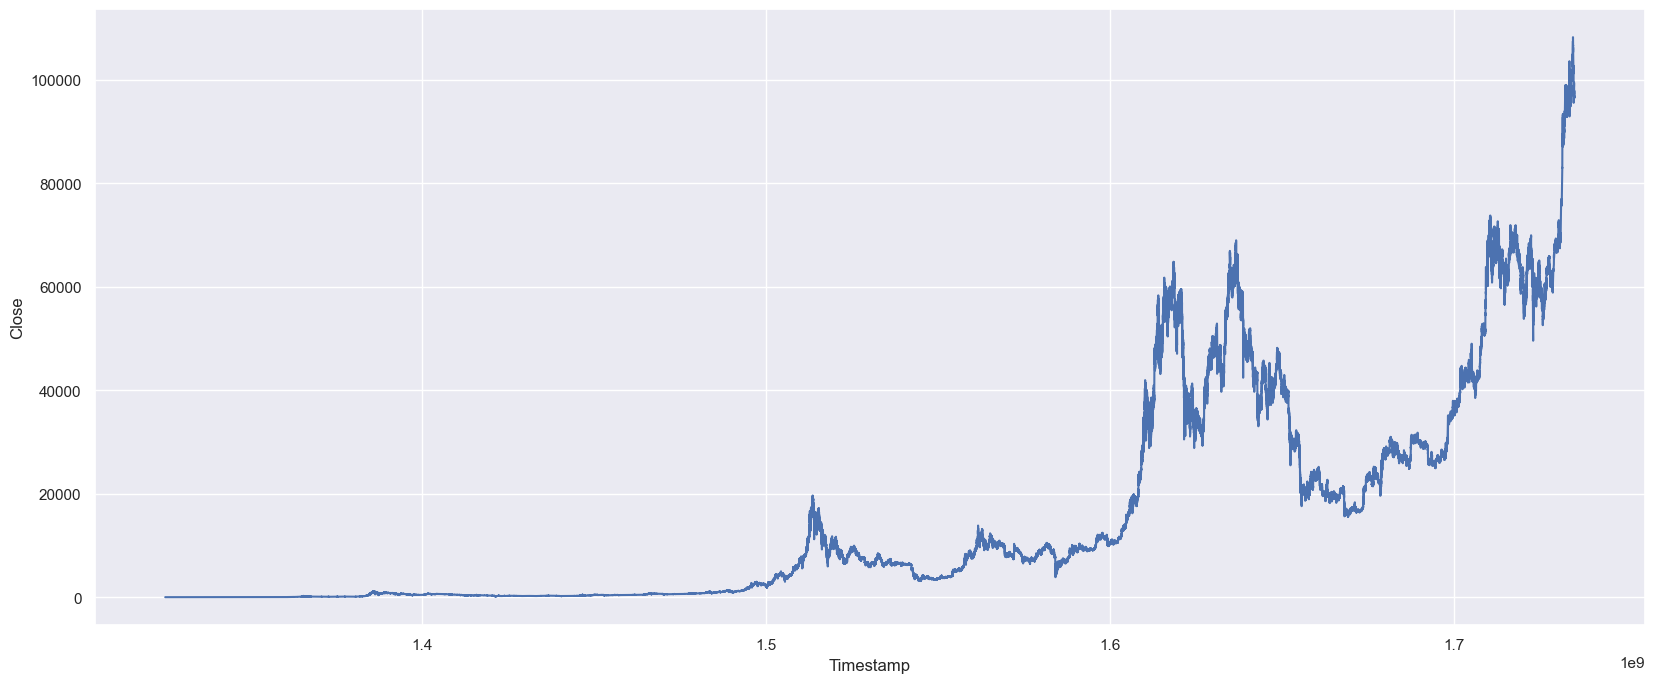

In [3]:
sns.set_theme(rc={"figure.figsize": (20, 8)})
plo = sns.lineplot(df, x='Timestamp', y='Close')


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset



In [5]:
data = df['Open'].values
data

array([4.5800e+00, 4.5800e+00, 4.5800e+00, ..., 9.7211e+04, 9.7245e+04,
       5.7854e+04])

In [6]:
# Criar as sequências
#'''
seq_len = 2
data = df['Open'].values

X = []
y = []
for i in range(len(data) - seq_len):
    
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len])


X = np.array(X)
y = np.array(y)
#'''

# Converter para tensores
'''X = df['Open']
y = df['Open']
'''


X = torch.tensor(X, dtype=torch.float32) # (batch_size, seq_len, 1)
y = torch.tensor(y, dtype=torch.float32)  # (batch_size,)

# Separar 80% para treino e 20% para teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Dados de treino:", X_train.shape, y_train.shape)
print("Dados de teste:", X_test.shape, y_test.shape)


Dados de treino: torch.Size([5385823, 2]) torch.Size([5385823])
Dados de teste: torch.Size([1346456, 2]) torch.Size([1346456])


In [7]:
X_train.shape

torch.Size([5385823, 2])

In [8]:


# Criar DataLoader para minibatches
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64  # Experimente diferentes tamanhos de lote
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, y = self.lstm(x)  # Saída da LSTM
        out = self.fc(out[:, -1, :])  # Previsão baseada na última saída
        return out

In [10]:
# Hiperparâmetros
input_dim = 1       # Apenas 1 feature ('Open')
hidden_dim = 50     # Número de neurônios na camada oculta
num_layers = 2      # Camadas LSTM
learning_rate = 0.001
num_epochs = 10

# Criar o modelo
model = LSTMRegressor(input_dim, hidden_dim, num_layers)
criterion = nn.MSELoss()  # Mean Squared Error para regressão
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Treinar o modelo

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Época [{epoch + 1}/{num_epochs}], Perda: {epoch_loss / len(train_loader):.4f}')


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 2

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).squeeze()
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))  # Desnormalizar
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Desnormalizar

# Exibir resultados
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores reais')
plt.plot(y_pred, label='Previsões', alpha=0.7)
plt.legend()
plt.title('Previsão de Preço de Ação')
plt.show()